# Jupyter Notebook Well Extraction Demonstration

This Jupyter Notebook provides an overview of the functions within the Meltyfat package, alongside their parameters developed for well detection and extraction. Additionally, it includes a tutorial on how to effectively utilize these functional classes.

**GitHub:** https://github.com/JiraLeelas/meltyfat <br>
**Author:** Jira Leelasoontornwatana <br>
**Update:** August 30, 2024 

In [1]:
## Include libraries required to operate
import os
import string
import re
import csv
import shutil
from itertools import islice
from datetime import datetime, timedelta

## libarires that required install
import torch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO

## Load this libary
import meltyfat
from meltyfat import *

### Define Extraction Parameters
| Parameters        | Description                                      |
|-------------------|--------------------------------------------------|
| `reference_image` | The path to the reference image location.        |
| `csv_vdo`         | The path to the VDO CSV location.                |
| `vdo_frames_dump` | The path to the folder to dump the frames.       |
| `extracted_dump`  | The path to the extracted output location.       |
| `output_filename` | The output filename for the CSV VDO.              |
| `sample_seconds`  | The number of frames sample at every specified intervals.    | |

In [3]:
## Required for extractions
reference_image = "example_data\empty_ref_plat_ghee_exp.jpeg"
csv_vdo = "example_data\HM202408191126Gheeheat70coolingOFF_video_Temperature Value.csv"

## Extraction
vdo_frames_dump = "example_framesdump"
extracted_dump = "example_output"
output_filename = "test_ghee_cooling_off.csv"
sample_seconds = 30

## Customized Extraction using Functions

This section provides a step-by-step approach to run temperature extraction from starting point from the initial reference image and a video CSV.

### 1. Run Well Detector
First the detector object is initialized with `reference_img_path` parameter. Users will have the opportunity to choose either apply the Hough Circles Transform `detect_HoughCircles()` or the YOLO object detection model `detect_YOLOv8()` to find the locations of all instances of the wells.

In [7]:
well_detector = WellDetector(reference_img_path=reference_image)

Device: cuda
Success: Image loaded


#### 1.1 Hough Circle Transform [Option 1]
The Hough Circle Transform for well detection is implemented from the openCV library. Certain parameters were adjusted to suit this application.
| Parameters    | Description | Default Value |
|--------------|----------------------------------------|---------------|
| `dp`| The invesrse raito of resolution. |1|
| `minDist`| Minimum distance between circle centers for detection. |10|
| `param1`| Canny edge detector high threshold.|200|
| `param2`| Center detection threshold. |10|
| `minRadius`| Minimum circle radius that the algorithm will detect. |12|
| `maxRadius`| Maximum circle radius that the algorithm will detect. |14|

**Reference:** https://docs.opencv.org/3.4/d4/d70/tutorial_hough_circle.html

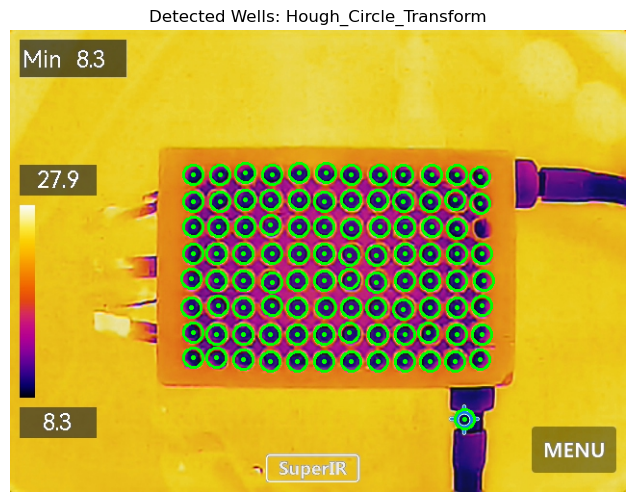

In [30]:
hough_results = well_detector.detect_HoughCircles(minDist=11, minRadius=10, maxRadius=11)

In [227]:
print(hough_results[:48]) # display half of the wells

[{'well_center': (190, 150), 'well_radius': 10, 'confidence': None}, {'well_center': (214, 342), 'well_radius': 10, 'confidence': None}, {'well_center': (488, 342), 'well_radius': 10, 'confidence': None}, {'well_center': (328, 148), 'well_radius': 10, 'confidence': None}, {'well_center': (410, 204), 'well_radius': 10, 'confidence': None}, {'well_center': (354, 344), 'well_radius': 10, 'confidence': None}, {'well_center': (436, 178), 'well_radius': 10, 'confidence': None}, {'well_center': (218, 206), 'well_radius': 10, 'confidence': None}, {'well_center': (492, 206), 'well_radius': 10, 'confidence': None}, {'well_center': (216, 232), 'well_radius': 10, 'confidence': None}, {'well_center': (300, 178), 'well_radius': 10, 'confidence': None}, {'well_center': (326, 342), 'well_radius': 10, 'confidence': None}, {'well_center': (410, 232), 'well_radius': 10, 'confidence': None}, {'well_center': (464, 316), 'well_radius': 10, 'confidence': None}, {'well_center': (216, 148), 'well_radius': 10, 

#### 1.2 YOLOv8 Custom Dataset [Option 2]
| Parameters    | Description | Default Value |
|--------------|----------------------------------------|---------------|
|`model_path`| The path to the trained well detection model. The default model is the third iteration of YOLOv8s. |default_model_rel_path |
|`conf_threshold`| Confidence threshold of the model for detection. | 0.25 |


0: 480x640 96 wells, 124.4ms
Speed: 7.5ms preprocess, 124.4ms inference, 8.7ms postprocess per image at shape (1, 3, 480, 640)


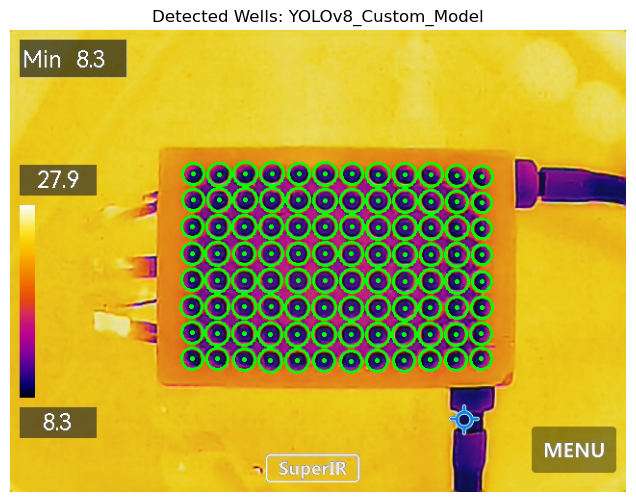

In [229]:
yolo_results = well_detector.detect_YOLOv8(conf_threshold=0.8)

In [230]:
print(yolo_results[:48]) # display half of the wells

[{'well_center': (410, 177), 'well_radius': 12, 'confidence': '0.90'}, {'well_center': (410, 289), 'well_radius': 12, 'confidence': '0.90'}, {'well_center': (410, 233), 'well_radius': 12, 'confidence': '0.89'}, {'well_center': (217, 176), 'well_radius': 12, 'confidence': '0.89'}, {'well_center': (354, 232), 'well_radius': 12, 'confidence': '0.89'}, {'well_center': (355, 177), 'well_radius': 12, 'confidence': '0.89'}, {'well_center': (243, 232), 'well_radius': 11, 'confidence': '0.89'}, {'well_center': (244, 176), 'well_radius': 12, 'confidence': '0.89'}, {'well_center': (464, 233), 'well_radius': 12, 'confidence': '0.89'}, {'well_center': (298, 288), 'well_radius': 12, 'confidence': '0.89'}, {'well_center': (299, 176), 'well_radius': 12, 'confidence': '0.89'}, {'well_center': (299, 232), 'well_radius': 11, 'confidence': '0.89'}, {'well_center': (354, 289), 'well_radius': 12, 'confidence': '0.89'}, {'well_center': (354, 344), 'well_radius': 11, 'confidence': '0.88'}, {'well_center': (46

### 2. Extract CSVs from Video CSV
To extract frames data, users can specify the sampling interval in seconds using the sample_sec parameter before applying the `map_csv()` function to execute the sampling process. The sampled frames will be stored as a list of dictionaries in memory using the `get_sampled_data()` function or can be saved as multiple CSV files using the `save_sampled_data()` function. The `save_sampled_data()` function requires a directory where all the extracted frame content will be saved. This method is particularly advantageous for long-duration experiments or when using a high `sample_sec` value.

| Parameters    | Description | Default Value |
|--------------|----------------------------------------|---------------|
|`sample_sec`| The number of frames sample at every specified intervals.  | 30 |

In [234]:
csv_extractor = HikExcelExtractor(vdo_csv=csv_vdo, sample_sec=sample_seconds)
csv_extractor.map_csv()

#### 2.1 Extract data into a list of dictionaries [Option 1]
This method stores the extracted frames data as a list of dictionaries.

In [236]:
frames = csv_extractor.get_sampled_data() # get a list of frames

In [237]:
print(frames[0]) # output sample

{'date': '2024-08-19', 'time': '12:19:16', 'data': [[21.8, 21.9, 21.7, 21.7, 21.6, 21.7, 21.5, 21.3, 21.5, 21.6, 21.5, 21.6, 21.3, 21.2, 21.2, 21.2, 21.4, 20.8, 21.2, 21.2, 21.1, 21.5, 21.0, 21.2, 21.3, 20.8, 21.0, 20.7, 20.9, 20.7, 20.8, 20.7, 19.9, 20.4, 19.8, 20.0, 19.8, 20.0, 20.0, 20.1, 19.9, 19.9, 19.9, 19.8, 19.6, 20.1, 20.1, 20.2, 20.0, 19.7, 20.1, 20.0, 19.9, 20.2, 19.6, 19.5, 19.7, 19.9, 19.9, 19.9, 19.8, 19.9, 19.7, 20.1, 19.9, 20.6, 20.8, 20.9, 20.8, 21.0, 20.7, 20.7, 20.4, 20.0, 19.7, 19.6, 19.9, 19.7, 20.0, 20.0, 19.9, 20.0, 19.8, 19.9, 19.8, 19.5, 19.8, 20.1, 19.6, 19.8, 19.6, 20.0, 19.6, 19.6, 19.5, 19.7, 19.9, 19.8, 19.9, 19.5, 20.1, 19.8, 19.7, 19.9, 19.9, 20.0, 19.7, 19.7, 19.5, 19.6, 19.7, 20.0, 19.8, 19.8, 19.7, 19.8, 19.7, 19.7, 19.7, 19.5, 19.6, 19.7, 19.9, 19.6, 19.7, 19.9, 19.8, 19.8, 20.0, 19.8, 19.5, 19.8, 19.8, 19.7, 19.9, 19.5, 19.8, 19.8, 19.8, 19.7, 20.1, 19.7, 19.7, 19.7, 19.7, 19.7, 19.8, 19.6, 19.9, 19.8, 19.8, 19.9, 19.9, 19.8, 20.0, 19.7, 19.8, 20.1,

#### 2.2 Extract data into a specified folder [Option 2]
This method is better to relived the memory issue by storing the frames in a local folder.

In [240]:
csv_extractor.save_sampled_data(save_dir=vdo_frames_dump)

Success: Saved to example_framesdump


### 3. Run extraction
To run extraction, `WellDetector` and `HikExcelExtractor` must be executed to get the reference coordinates and the frames list prior to invoking this class. Users have the choice of input a list of frames dictionary or as a path towards the frames folder into this `WellTempExtractor` class. The extraction process is initiated using `run_TempExtract()` function. With the extracted data, the `get_extractedDF()` is used to access the data as a dataframe. The extracted dataframe can be saved into a specified directory via `get_extractedCSV()`.
| Parameters    | Description | Default Value |
|--------------|----------------------------------------|---------------|
|`ref_img_path`| The path to the reference image location. | NA - Required |
|`detected_wells`| The list of dictionaries from the detected wells. | NA - Required |
|`frame_dataORpath`| Either the frames data or the path the the frames CSVs dump are provided. | NA - Required |
|`output_path`| Output path for the extracted file. | NA - Required |
|`detect_window`| Detect window to apply window average method (max 5). | 3 |
|`image_invert_status`| The wellplate invert status. Normally, the well plate is inverted from the user's position. | False |
|`output_filename`| The filename for the recorded output. | datepart_timepart_extracted.csv |

#### 3.1 Get frames data from a list of dictionary 
This example provides the process of extracting temperatures from each wells from a list of frame dictionaries.

In [245]:
well_extractor = WellTempExtractor(ref_image_path=reference_image, detected_wells=yolo_results, frame_dataORpath=frames, output_path=extracted_dump, detect_window=5, image_invert_status=True, output_filename=output_filename)

In [246]:
well_extractor.run_TempExtract()

Success: Image loaded


In [247]:
## dataframe
extracted_df = well_extractor.get_extractedDF()
display(extracted_df)

,Date,Time,A1,A2,A3,A4,A5,A6,A7,A8,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,2024-08-19,12:19:16,19.24,20.54,22.99,25.48,27.84,29.97,32.15,34.26,...,21.88,24.22,26.99,28.56,30.83,32.75,34.81,36.72,39.16,38.09
1,2024-08-19,12:19:46,20.92,22.05,24.18,26.26,28.77,30.45,32.48,34.53,...,23.11,25.16,27.50,29.09,31.17,33.00,34.97,36.78,39.19,38.08
2,2024-08-19,12:20:16,23.29,24.55,26.53,28.13,30.11,31.90,33.77,35.68,...,25.36,27.19,29.26,30.56,32.52,34.24,36.01,37.65,39.99,38.75
3,2024-08-19,12:20:46,25.67,27.77,29.34,30.48,32.39,34.05,35.82,37.62,...,27.81,29.56,31.47,32.58,34.37,36.00,37.65,39.24,41.57,40.10
4,2024-08-19,12:21:16,28.34,30.16,32.30,33.09,34.94,36.52,38.24,39.99,...,30.49,32.19,34.02,34.96,36.73,38.31,39.92,41.39,43.81,42.16
5,2024-08-19,12:21:46,30.80,33.07,35.30,35.80,37.65,39.20,40.92,42.60,...,33.22,34.92,36.70,37.47,39.22,40.76,42.28,43.65,46.09,44.08
6,2024-08-19,12:22:16,33.94,36.30,38.78,39.00,40.89,42.45,44.23,45.88,...,36.26,38.02,39.83,40.54,42.24,43.74,45.03,46.37,48.97,46.55
7,2024-08-19,12:22:46,36.85,39.57,41.36,42.26,44.22,45.78,47.55,49.09,...,39.37,41.14,43.01,43.51,45.19,46.65,47.88,49.08,51.63,48.69
8,2024-08-19,12:23:16,39.98,44.14,44.93,45.59,47.55,48.99,50.59,51.88,...,42.62,44.34,46.22,46.45,47.90,49.16,50.14,51.00,53.25,49.78
9,2024-08-19,12:23:46,42.60,46.04,47.89,48.33,50.14,51.41,52.84,53.77,...,45.75,47.39,49.16,49.12,50.37,51.37,51.98,52.52,54.41,50.51


In [248]:
well_extractor.get_extractedCSV()

Success: Exported to example_output\test_ghee_cooling_off.csv


#### 3.2 Get frames data from a folder of CSVs
This example provides the process of extracting temperatures from each wells from a folder of CSVs.

In [250]:
well_extractor_csv = WellTempExtractor(ref_image_path=reference_image, detected_wells=yolo_results, frame_dataORpath=vdo_frames_dump, output_path=extracted_dump, detect_window=5, image_invert_status=True, output_filename=output_filename)

example_framesdump


In [251]:
well_extractor_csv.run_TempExtract()

Success: Image loaded


In [252]:
extracted_csv_df = well_extractor_csv.get_extractedDF()
display(extracted_csv_df)

,Date,Time,A1,A2,A3,A4,A5,A6,A7,A8,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,2024-08-19,12:19:16,19.24,20.54,22.99,25.48,27.84,29.97,32.15,34.26,...,21.88,24.22,26.99,28.56,30.83,32.75,34.81,36.72,39.16,38.09
1,2024-08-19,12:19:46,20.92,22.05,24.18,26.26,28.77,30.45,32.48,34.53,...,23.11,25.16,27.50,29.09,31.17,33.00,34.97,36.78,39.19,38.08
2,2024-08-19,12:20:16,23.29,24.55,26.53,28.13,30.11,31.90,33.77,35.68,...,25.36,27.19,29.26,30.56,32.52,34.24,36.01,37.65,39.99,38.75
3,2024-08-19,12:20:46,25.67,27.77,29.34,30.48,32.39,34.05,35.82,37.62,...,27.81,29.56,31.47,32.58,34.37,36.00,37.65,39.24,41.57,40.10
4,2024-08-19,12:21:16,28.34,30.16,32.30,33.09,34.94,36.52,38.24,39.99,...,30.49,32.19,34.02,34.96,36.73,38.31,39.92,41.39,43.81,42.16
5,2024-08-19,12:21:46,30.80,33.07,35.30,35.80,37.65,39.20,40.92,42.60,...,33.22,34.92,36.70,37.47,39.22,40.76,42.28,43.65,46.09,44.08
6,2024-08-19,12:22:16,33.94,36.30,38.78,39.00,40.89,42.45,44.23,45.88,...,36.26,38.02,39.83,40.54,42.24,43.74,45.03,46.37,48.97,46.55
7,2024-08-19,12:22:46,36.85,39.57,41.36,42.26,44.22,45.78,47.55,49.09,...,39.37,41.14,43.01,43.51,45.19,46.65,47.88,49.08,51.63,48.69
8,2024-08-19,12:23:16,39.98,44.14,44.93,45.59,47.55,48.99,50.59,51.88,...,42.62,44.34,46.22,46.45,47.90,49.16,50.14,51.00,53.25,49.78
9,2024-08-19,12:23:46,42.60,46.04,47.89,48.33,50.14,51.41,52.84,53.77,...,45.75,47.39,49.16,49.12,50.37,51.37,51.98,52.52,54.41,50.51


In [253]:
well_extractor_csv.get_extractedCSV()

Success: Exported to example_output\test_ghee_cooling_off.csv
